In [ ]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder

In [ ]:
df = pd.read_csv('Flight_delay.csv')

In [ ]:
df.head()

,DayOfWeek,Date,DepTime,ArrTime,CRSArrTime,UniqueCarrier,Airline,FlightNum,TailNum,ActualElapsedTime,...,TaxiIn,TaxiOut,Cancelled,CancellationCode,Diverted,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay
0,4,03-01-2019,1829,1959,1925,WN,Southwest Airlines Co.,3920,N464WN,90,...,3,10,0,N,0,2,0,0,0,32
1,4,03-01-2019,1937,2037,1940,WN,Southwest Airlines Co.,509,N763SW,240,...,3,7,0,N,0,10,0,0,0,47
2,4,03-01-2019,1644,1845,1725,WN,Southwest Airlines Co.,1333,N334SW,121,...,6,8,0,N,0,8,0,0,0,72
3,4,03-01-2019,1452,1640,1625,WN,Southwest Airlines Co.,675,N286WN,228,...,7,8,0,N,0,3,0,0,0,12
4,4,03-01-2019,1323,1526,1510,WN,Southwest Airlines Co.,4,N674AA,123,...,4,9,0,N,0,0,0,0,0,16


selecting columns

In [ ]:
df = df[['DayOfWeek','Date','DepTime','Airline','Origin','Dest','CarrierDelay']]
df

,DayOfWeek,Date,DepTime,Airline,Origin,Dest,CarrierDelay
0,4,03-01-2019,1829,Southwest Airlines Co.,IND,BWI,2
1,4,03-01-2019,1937,Southwest Airlines Co.,IND,LAS,10
2,4,03-01-2019,1644,Southwest Airlines Co.,IND,MCO,8
3,4,03-01-2019,1452,Southwest Airlines Co.,IND,PHX,3
4,4,03-01-2019,1323,Southwest Airlines Co.,IND,TPA,0
...,...,...,...,...,...,...,...
484546,5,13-06-2019,1609,American Airlines Inc.,DFW,MCO,27
484547,6,14-06-2019,1616,American Airlines Inc.,DFW,MCO,11
484548,2,17-06-2019,1617,American Airlines Inc.,DFW,MCO,0
484549,7,22-06-2019,1607,American Airlines Inc.,DFW,MCO,1


In [ ]:
# we have to convert all the categorical variables into numerical because xgboost
# doesnt take categorical data as input
# so converting date time into pandas date time format so that its features can be extracted
df['Date'] = pd.to_datetime(df['Date'],dayfirst= True)

In [ ]:
df['month'] = df['Date'].dt.month
df['day'] = df['Date'].dt.day

# Drop the original 'Date' column since XGBoost doesn't handle datetime types
df = df.drop(columns=['Date'])

Check for missing data

In [ ]:
df.isnull().sum()

,0
DayOfWeek,0
DepTime,0
Airline,0
Origin,0
Dest,0
CarrierDelay,0
month,0
day,0


Identify categorical variables

In [ ]:
categories = df.select_dtypes(include=['object']).columns
categories

Index(['Airline', 'Origin', 'Dest'], dtype='object')

Preparing target variable

In [ ]:
df['is_delayed_60+'] = np.where(df['CarrierDelay'] > 60, 1, 0)

Creating a copy of df before label encoding its categorical variables , so that we can use the categories for data analysis later and use the label encoded values for the xgboost model

In [ ]:
train_set = df.copy()

In [ ]:
for category in categories:
    encoder = LabelEncoder()
    df[category] = encoder.fit_transform(df[category])

Splitting into training and testing data by splitting the target and feature values

In [ ]:
X = df.drop(columns=['is_delayed_60+', 'CarrierDelay'])
y = df['is_delayed_60+']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

In [ ]:
# Reversing one-hot encoding for multiple sets of categorical variables
# for category in categories:
#     one_hot_columns = [col for col in train_set.columns if col.startswith(f'{category}_')]
#     train_set[category] = train_set[one_hot_columns].idxmax(axis=1)
#     train_set = train_set.drop(columns=one_hot_columns)
#     train_set[category] = train_set[category].str.replace(f'{category}_', '')

In [ ]:
train_set

,DayOfWeek,DepTime,Airline,Origin,Dest,CarrierDelay,month,day,is_delayed_60+
0,4,1829,Southwest Airlines Co.,IND,BWI,2,1,3,0
1,4,1937,Southwest Airlines Co.,IND,LAS,10,1,3,0
2,4,1644,Southwest Airlines Co.,IND,MCO,8,1,3,0
3,4,1452,Southwest Airlines Co.,IND,PHX,3,1,3,0
4,4,1323,Southwest Airlines Co.,IND,TPA,0,1,3,0
...,...,...,...,...,...,...,...,...,...
484546,5,1609,American Airlines Inc.,DFW,MCO,27,6,13,0
484547,6,1616,American Airlines Inc.,DFW,MCO,11,6,14,0
484548,2,1617,American Airlines Inc.,DFW,MCO,0,6,17,0
484549,7,1607,American Airlines Inc.,DFW,MCO,1,6,22,0


In [ ]:
train_set['is_delayed_60+'].value_counts()

,count
is_delayed_60+,
0,448259
1,36292


In [ ]:
train_set['is_delayed_60+'].mean()

0.07489820472973949

In [ ]:
train_set.groupby('Airline')['is_delayed_60+'].mean().sort_values(ascending=False).round(3)*100

,is_delayed_60+
Airline,
Atlantic Southeast Airlines,16.3
Hawaiian Airlines Inc.,13.5
Skywest Airlines Inc.,10.2
Alaska Airlines Inc.,9.6
American Airlines Inc.,8.9
Delta Air Lines Inc.,8.4
United Air Lines Inc.,7.8
US Airways Inc.,7.5
American Eagle Airlines Inc.,7.0


In [ ]:
DayOfWeek_pct_delayed = train_set.groupby('DayOfWeek')['is_delayed_60+'].mean().round(3)*100
DayOfWeek_pct_delayed

,is_delayed_60+
DayOfWeek,
1,7.6
2,7.1
3,7.7
4,6.9
5,6.8
6,9.1
7,7.9


In [ ]:
# delay60+ -> mean -> till 3 decimal places -> percentage
pct_delay_by_origin = train_set.groupby('Origin')['is_delayed_60+'].mean().sort_values(ascending=False).round(3)*100
pct_delay_by_origin.head(20)

,is_delayed_60+
Origin,
LWB,41.7
ACY,40.0
MQT,39.2
SLE,29.4
SCE,25.0
ABI,24.8
MCN,23.9
TRI,23.5
FAY,23.0


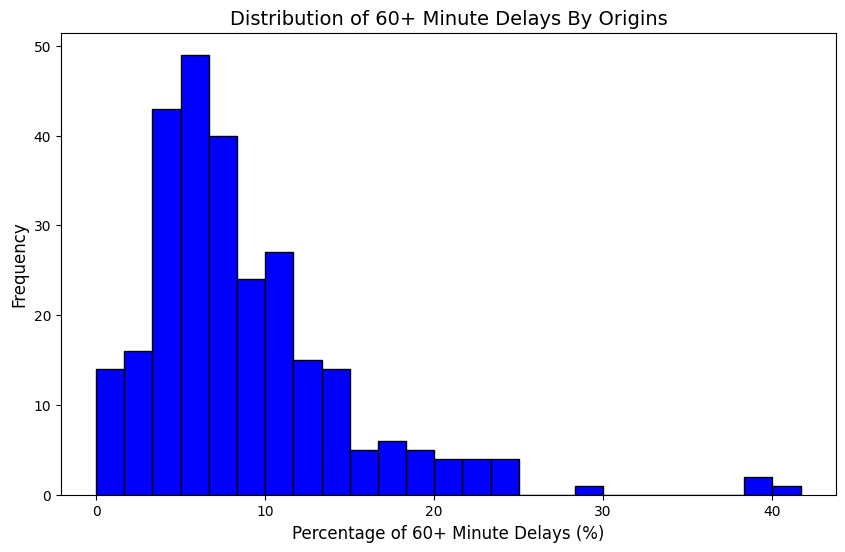

In [ ]:
# Plot histogram
# histogram is value on x axis and freq on y axis
plt.figure(figsize=(10, 6))
plt.hist(pct_delay_by_origin.values, bins=25, color='blue', edgecolor='black')

# Add labels and title
plt.title("Distribution of 60+ Minute Delays By Origins", fontsize=14)
plt.xlabel("Percentage of 60+ Minute Delays (%)", fontsize=12)
plt.ylabel("Frequency", fontsize=12)

# Show the plot
plt.show()

In [ ]:
!pip install scikit-learn
from sklearn.neighbors import KNeighborsClassifier

In [ ]:
# knn = KNeighborsClassifier(n_neighbors=3)  # You can adjust n_neighbors
# knn.fit(X_train, y_train)

In [ ]:
# y_pred = knn.predict(X_test)

In [ ]:
# # Assuming y_pred and y_test are already defined
# accuracy = accuracy_score(y_test, y_pred)

# # Print the accuracy
# print(f"Accuracy: {accuracy:.2f}")

In [ ]:
# Convert to DMatrix format for XGBoost
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

# Set parameters
params = {
    'objective': 'binary:logistic',
    'eval_metric': 'logloss'
}

# Boosting is an ensemble technique where new models (usually decision trees) are trained to correct the errors of the previous models.
# In XGBoost, boosting rounds refer to the number of times trees will be added to the model to improve its performance.
# Each round of boosting adds one tree to the model, and each tree tries to improve the predictions by minimizing the loss (i.e., improving the model's accuracy).
# Train the model
model = xgb.train(params, dtrain, num_boost_round=100)

# Make predictions
y_pred_prob = model.predict(dtest)

In [ ]:
# Convert probabilities to binary predictions (0 or 1)
y_pred = (y_pred_prob > 0.5).astype(int)  # If probability > 0.5, predict 1, else 0

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

# Accuracy= (TP + TN)/(TP+TN+FP+FN)

Accuracy: 0.92


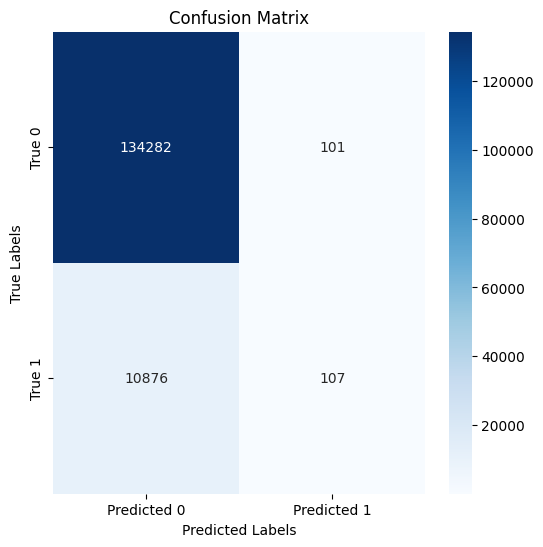

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Generate the confusion matrix
cm = confusion_matrix(y_test, y_pred)
# [[ TN, FP ],
#  [ FN, TP ]]

# Plot the confusion matrix using a heatmap
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['True 0', 'True 1'])
plt.xlabel('Predicted Labels')  # These are the predicted labels (model output)
plt.ylabel('True Labels')      # These are the true labels (actual ground truth)
plt.title('Confusion Matrix')
plt.show()

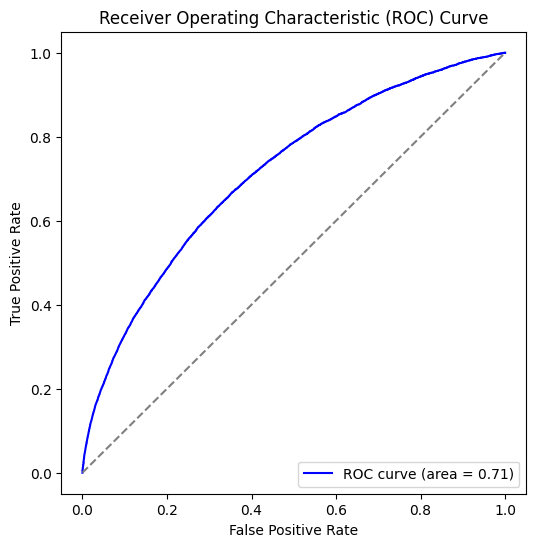

In [ ]:
from sklearn.metrics import roc_curve, auc

#  Receiver Operating Characteristic (ROC) curve and calculates the Area Under the Curve (AUC),
#  which is a commonly used metric to evaluate the performance of classification models


# Compute the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

# Compute the AUC
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

Step-by-Step Curve Construction
Start at the origin (0, 0):

When the threshold is very high (e.g., 1), no predictions are classified as positive.
TPR = 0 and FPR = 0 (since the classifier is making no positive predictions at all).
Iteratively lower the threshold:

As the threshold decreases, more instances are classified as positive:

True Positive Rate (TPR) increases because more actual positive samples are correctly classified.

False Positive Rate (FPR) also increases because more actual negative samples are incorrectly classified as positive.

Plot a point for each threshold:

Each unique threshold produces a corresponding (FPR, TPR) point on the graph.

End at (1, 1):

When the threshold is 0, all instances are classified as positive:

TPR = 1 (all true positives are captured).

FPR = 1 (all true negatives are incorrectly classified as positive).


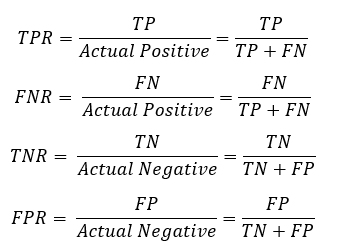

 The FPR (False Positive Rate) and TPR (True Positive Rate) arrays returned by roc_curve contain the values of FPR and TPR at each threshold.

In [ ]:
# so this is basically an array with the fpr from start till that data point
fpr

array([0.        , 0.        , 0.        , ..., 0.99927074, 0.99927074,
       1.        ])

In [ ]:
tpr

array([0.00000000e+00, 9.10498042e-05, 1.82099608e-04, ...,
       9.99908950e-01, 1.00000000e+00, 1.00000000e+00])

Step-by-step Process:
Model Predictions: First, the model outputs predicted probabilities for each instance. For example, these values might range from 0 to 1.

Thresholds: The roc_curve function then sorts these predicted probabilities and iterates through them, considering each unique probability as a potential threshold. So, it doesn't look at individual data points one by one; instead, it looks at each unique probability value from the model's output as a potential threshold.

Iteration: For each threshold, the function computes the corresponding True Positive Rate (TPR) and False Positive Rate (FPR):

At threshold = 1: Only instances with a predicted probability greater than or equal to 1 are classified as positive. This usually results in low TPR and low FPR (the classifier is very conservative).

As the threshold decreases (e.g., from 1 to 0.9, 0.8, and so on), more instances are classified as positive, which increases both TPR and FPR.

At threshold = 0: Nearly all instances are classified as positive, leading to high TPR and high FPR (the classifier is very liberal).

Final Thresholds: The function returns an array of thresholds that corresponds to the points at which TPR and FPR were calculated. These thresholds are sorted in descending order, meaning that the first threshold is the highest (1) and the last threshold is the lowest (0).

In [ ]:
thresholds

array([          inf, 8.5488504e-01, 8.3392251e-01, ..., 1.9857169e-03,
       1.9835674e-03, 4.5352278e-04], dtype=float32)

AUC is a number between 0 and 1 that indicates how well the model distinguishes between the classes.

AUC = 0.5: The model performs no better than random guessing (i.e., it’s not a good model).

AUC = 1.0: The model perfectly classifies all instances (i.e., it’s a perfect model).

Higher AUC values represent better performance. An AUC of 0.8–0.9 is generally considered very good, and 0.7–0.8 is acceptable.

In [ ]:
roc_auc

0.7143615411301949